# final project - KICKSTARTER

**What is Kickstarter?**

Kickstarter is a funding platform for creative projects. Everything from film, games, and music to art, design, and technology. Kickstarter is full of ambitious, innovative, and imaginative projects that are brought to life through the direct support of others.

Every project creator sets their project's funding goal and deadline. If people like the project, they can pledge money to make it happen. If the project succeeds in reaching its funding goal, all backers' credit cards are charged when time expires. Funding on Kickstarter is all-or-nothing. If the project falls short of its funding goal, no one is charged.

**Objective**

Goal of this analysis it to be able to predict whether or not a project will receive it's goal funds.

**Data Source:**

https://webrobots.io/kickstarter-datasets/

## import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import math
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# scipy libraries
from scipy import stats
from scipy.stats.mstats import winsorize

# statsmodels libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols

# sklearn libraries
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

# balancing libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## import data

In [2]:
from src.math_functions import create_dataframe

df = create_dataframe()

## first review and clean data

### review

In [3]:
print("This dataset contains {} rows and {} columns".format(*df.shape))

This dataset contains 543589 rows and 39 columns


In [4]:
df.sample(5)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,usd_exchange_rate
1491,19,An original fantasy film by John M. Hollback,"{""id"":296,""name"":""Fantasy"",""analytics_name"":""F...",1315,US,the United States,1493585957,"{""id"":829746574,""name"":""John Hollback"",""is_reg...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1505857294,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1315.00,international,1.0
2082,24,Nintendo inspired screen printed T-shirts and ...,"{""id"":263,""name"":""Apparel"",""analytics_name"":""A...",1335,US,the United States,1600616783,"{""id"":104575798,""name"":""Robyn K Lee"",""slug"":""r...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1604782592,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1335.00,international,NaN
2645,2,BLACK AND OVER 40 ...,"{""id"":322,""name"":""R&B"",""analytics_name"":""R&B"",...",41,US,the United States,1598470005,"{""id"":1262072852,""name"":""Maisha Sapp Woodley"",...",USD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1606933856,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",41.00,international,1.0
1845,9,Small Town Coffee shop providing a variety of ...,"{""id"":307,""name"":""Drinks"",""analytics_name"":""Dr...",387,US,the United States,1548947577,"{""id"":816762159,""name"":""Jaime Albers"",""slug"":""...",USD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1555725033,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",387.00,international,NaN
2942,134,Seattle based singer/songwriter Tekla Waterfie...,"{""id"":37,""name"":""Country & Folk"",""analytics_na...",6634,US,the United States,1580508814,"{""id"":104774315,""name"":""Tekla Waterfield"",""slu...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1583136484,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",6634.66,international,NaN


### review column names

In [5]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable', 'is_starred',
       'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type', 'usd_exchange_rate'],
      dtype='object')

no cleaning of column names required

### Drop Duplicates

In [7]:
from src.math_functions import drop_and_compare_duplicates

drop_and_compare_duplicates(df)

228 rows have been dropped!


### drop duplicate projects with different values

#### check for duplicate projects

In [8]:
df.duplicated(subset='id', keep='first').sum()

341154

#### review duplicates

In [9]:
df[df.duplicated(subset=['id'],keep=False)].sort_values(by=['id'])

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,usd_exchange_rate
736,4,Raising money to help my grandmother recover f...,"{""id"":44,""name"":""World Music"",""analytics_name""...",62,US,the United States,1476879198,"{""id"":1501687606,""name"":""Devan Porter"",""is_reg...",USD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1479479560,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",62.000000,international,1.000000
1763,4,Raising money to help my grandmother recover f...,"{""id"":44,""name"":""World Music"",""analytics_name""...",62,US,the United States,1476879198,"{""id"":1501687606,""name"":""Devan Porter"",""is_reg...",USD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1479479560,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",62.000000,international,NaN
846,11,My work is performance based but I branch out ...,"{""id"":24,""name"":""Performance Art"",""analytics_n...",262,GB,the United Kingdom,1428415625,"{""id"":923770533,""name"":""Fiona Powell"",""is_regi...",GBP,£,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1430946012,1.491538,"{""web"":{""project"":""https://www.kickstarter.com...",258.036032,international,1.518587
2584,11,My work is performance based but I branch out ...,"{""id"":24,""name"":""Performance Art"",""analytics_n...",262,GB,the United Kingdom,1428415625,"{""id"":923770533,""name"":""Fiona Powell"",""is_regi...",GBP,£,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1430946012,1.491538,"{""web"":{""project"":""https://www.kickstarter.com...",258.036032,international,NaN
305,18,A sanctuary for humans and felines alike! Come...,"{""id"":314,""name"":""Spaces"",""analytics_name"":""Sp...",776,US,the United States,1445787145,"{""id"":920978851,""name"":""Tori"",""is_registered"":...",USD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1448555133,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",776.000000,international,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,0,Would like to be able to photograph dream wedd...,"{""id"":276,""name"":""Fine Art"",""analytics_name"":""...",0,CA,Canada,1404849038,"{""id"":667466823,""name"":""Laura"",""is_registered""...",CAD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1406215380,0.938523,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,international,0.931290
2927,0,Would like to be able to photograph dream wedd...,"{""id"":276,""name"":""Fine Art"",""analytics_name"":""...",0,CA,Canada,1404849038,"{""id"":667466823,""name"":""Laura"",""is_registered""...",CAD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1406215380,0.938523,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,international,0.931290
1612,0,Would like to be able to photograph dream wedd...,"{""id"":276,""name"":""Fine Art"",""analytics_name"":""...",0,CA,Canada,1404849038,"{""id"":667466823,""name"":""Laura"",""is_registered""...",CAD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1406215380,0.938523,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,international,NaN
1498,2076,"COLD, FRESH, & CARBONATED wherever you go! Cas...","{""id"":307,""name"":""Drinks"",""analytics_name"":""Dr...",304142,US,the United States,1417200147,"{""id"":584321487,""name"":""Drink Tanks"",""is_regis...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1428631231,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",304142.000000,international,1.000000


#### drop double listing of projects

In [10]:
df = (df.sort_values(by=['id', 'converted_pledged_amount'], ascending=False).drop_duplicates(subset='id', keep= 'first').reset_index(drop=True))

#### set id as index and review shape after drop

In [11]:
df = df.set_index('id')

In [12]:
df.shape

(202435, 38)

### extract category information

In [13]:
from src.math_functions import get_category_data

get_category_data('category', df)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,usd_exchange_rate,category_name,category_analytics_name,category_slug,category_parent_name
id,,,,,,,,,,,,,,,,,,,,,
2147476221,2076,"COLD, FRESH, & CARBONATED wherever you go! Cas...","{""id"":307,""name"":""Drinks"",""analytics_name"":""Dr...",304142,US,the United States,1417200147,"{""id"":584321487,""name"":""Drink Tanks"",""is_regis...",USD,$,...,1428631231,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",304142.000000,international,NaN,Drinks,Drinks,food/drinks,Food
2147466649,0,Would like to be able to photograph dream wedd...,"{""id"":276,""name"":""Fine Art"",""analytics_name"":""...",0,CA,Canada,1404849038,"{""id"":667466823,""name"":""Laura"",""is_registered""...",CAD,$,...,1406215380,0.938523,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,international,NaN,Fine Art,Fine Art,photography/fine art,Photography
2147460119,53,MOMENTS OF INSIGHT is a project consisting of ...,"{""id"":20,""name"":""Conceptual Art"",""analytics_na...",18758,US,the United States,1303753700,"{""id"":1743305220,""name"":""Chaucer Silverson"",""i...",USD,$,...,1312432269,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",18758.000000,international,NaN,Conceptual Art,Conceptual Art,art/conceptual art,Art
2147437278,52,"Growing fish and produce year round in the ""Po...","{""id"":305,""name"":""Community Gardens"",""analytic...",2460,CA,Canada,1419960769,"{""id"":1810768137,""name"":""Earl Decker"",""is_regi...",CAD,$,...,1423675583,0.860877,"{""web"":{""project"":""https://www.kickstarter.com...",2660.971116,international,NaN,Community Gardens,Community Gardens,food/community gardens,Food
2147430599,13,An oboe recital with music and photography to ...,"{""id"":36,""name"":""Classical Music"",""analytics_n...",915,US,the United States,1375640768,"{""id"":1763180118,""name"":""Jennifer Stucki"",""is_...",USD,$,...,1379825940,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",915.000000,international,NaN,Classical Music,Classical Music,music/classical music,Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38736,3,All your herbal tea remedies here. From colds ...,"{""id"":307,""name"":""Drinks"",""analytics_name"":""Dr...",96,US,the United States,1534903328,"{""id"":160842473,""name"":""Vito Finazzo"",""is_regi...",USD,$,...,1540093916,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",96.000000,international,NaN,Drinks,Drinks,food/drinks,Food
33867,42,Taste Makers is a socially conscious brand tha...,"{""id"":269,""name"":""Ready-to-wear"",""analytics_na...",2158,CA,Canada,1426394434,"{""id"":1827655104,""name"":""Taste Makers By Trish...",CAD,$,...,1438280891,0.811910,"{""web"":{""project"":""https://www.kickstarter.com...",2271.723453,international,NaN,Ready-to-wear,Ready-to-wear,fashion/ready-to-wear,Fashion
24380,18,A sanctuary for humans and felines alike! Come...,"{""id"":314,""name"":""Spaces"",""analytics_name"":""Sp...",776,US,the United States,1445787145,"{""id"":920978851,""name"":""Tori"",""is_registered"":...",USD,$,...,1448555133,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",776.000000,international,NaN,Spaces,Spaces,food/spaces,Food


In [14]:
df['category_parent_name'].value_counts()

Film & Video    27110
Music           26208
Technology      20471
Art             20347
Publishing      20174
Food            15651
Games           13303
Fashion         10992
Design           8184
Comics           7525
Photography      6633
Crafts           5859
Theater          5113
Journalism       3928
Dance            1831
Name: category_parent_name, dtype: int64

### review dtypes

In [15]:
### Review DTypes

df.dtypes

# boolean columns death_event, smoking, sex, high_blood_pressure, diabetes, anaemia
# df = df.astype({'death_event':'boolean', 'sex':'boolean', 'smoking':'boolean', 'high_blood_pressure':'boolean','diabetes':'boolean','anaemia':'boolean','age':'int64'})


#df = df.astype({'polarity':'int64', 'subjectivity':'int64'})

df.dtypes

backers_count                 int64
blurb                        object
category                     object
converted_pledged_amount      int64
country                      object
country_displayable_name     object
created_at                    int64
creator                      object
currency                     object
currency_symbol              object
currency_trailing_code         bool
current_currency             object
deadline                      int64
disable_communication          bool
friends                      object
fx_rate                     float64
goal                        float64
is_backing                   object
is_starrable                   bool
is_starred                   object
launched_at                   int64
location                     object
name                         object
permissions                  object
photo                        object
pledged                     float64
profile                      object
slug                        

to review

### Null Values

In [16]:
df.isna().any()

backers_count               False
blurb                        True
category                    False
converted_pledged_amount    False
country                     False
country_displayable_name    False
created_at                  False
creator                     False
currency                    False
currency_symbol             False
currency_trailing_code      False
current_currency            False
deadline                    False
disable_communication       False
friends                      True
fx_rate                     False
goal                        False
is_backing                   True
is_starrable                False
is_starred                   True
launched_at                 False
location                     True
name                        False
permissions                  True
photo                       False
pledged                     False
profile                     False
slug                        False
source_url                  False
spotlight     

No null values present in this dataset

### Data Values

In [17]:
for col in df:
    print(df[col].value_counts(), '\n')

1       15888
0       15585
2       11282
3        7712
4        5551
        ...  
2118        1
2630        1
9027        1
4933        1
1727        1
Name: backers_count, Length: 3543, dtype: int64 

ALL-NEW SEXY BADGIRL characters from comic book INDIE legend Everette Hartsoe. 100% artwork in book                                      27
Hard Enamel Pins                                                                                                                         20
The Decentralized Dance Party was founded on the belief that Partying is an art form that has the power to change the world.             17
A beautiful natural Fine art nude book exemplifying the female form presented by female producer Nina Vain.                              14
.                                                                                                                                        14
                                                                                                

Name: is_backing, dtype: int64 

False    197222
True       5213
Name: is_starrable, dtype: int64 

False    86
True      1
Name: is_starred, dtype: int64 

1623769204    3
1605020400    3
1613160001    3
1615903201    3
1617296400    3
             ..
1514778526    1
1512671131    1
1552298716    1
1444064402    1
1415583747    1
Name: launched_at, Length: 202189, dtype: int64 

{"id":2442047,"name":"Los Angeles","slug":"los-angeles-ca","short_name":"Los Angeles, CA","displayable_name":"Los Angeles, CA","localized_name":"Los Angeles","country":"US","state":"CA","type":"Town","is_root":false,"expanded_country":"United States","urls":{"web":{"discover":"https://www.kickstarter.com/discover/places/los-angeles-ca","location":"https://www.kickstarter.com/locations/los-angeles-ca"},"api":{"nearby_projects":"https://api.kickstarter.com/v1/discover?signature=1618556896.550be3fe53fdf272b61e696f43eb459e766de27a&woe_id=2442047"}}}                                                     6511
{"id":44

{"id":3347400,"project_id":3347400,"state":"active","state_changed_at":1529986186,"name":"Mochi Kids- Modern Unisex Childrenswear made in the USA","blurb":"Comfortable, stylish apparel designed with kids and parents in mind.","background_color":"","text_color":"","link_background_color":"4f5356","link_text_color":"","link_text":"Follow along!","link_url":"http://www.mochikidsco.com","show_feature_image":false,"background_image_opacity":0.8,"should_show_feature_image_section":true,"feature_image_attributes":{"image_urls":{"default":"https://ksr-ugc.imgix.net/assets/021/370/170/bbb5585cd78dcc753531c8975d8d2ff8_original.jpg?ixlib=rb-2.1.0&crop=faces&w=1552&h=873&fit=crop&v=1527610432&auto=format&frame=1&q=92&s=72faeb57012d6f3747876c8d0ae760fb","baseball_card":"https://ksr-ugc.imgix.net/assets/021/370/170/bbb5585cd78dcc753531c8975d8d2ff8_original.jpg?ixlib=rb-2.1.0&crop=faces&w=560&h=315&fit=crop&v=1527610432&auto=format&frame=1&q=92&s=46785bc3e6d68d5180005138cb6ca2bf"}}}                  

hannah-k-vincent-footprint-dance-festival-performa    1
mermay-2018-artbook                                   1
i-got-the-party-music-video-creation                  1
ouroboros-life-3p                                     1
deadlights-magazine                                   1
                                                     ..
safe-tub-faucet                                       1
help-me-end-poverty-and-suffering-with-an-online-b    1
yes-and-no-movie                                      1
the-plantarion-show-and-podcast                       1
gladiator-fight-to-the-finish                         1
Name: slug, Length: 202435, dtype: int64 

https://www.kickstarter.com/discover/categories/design                     2539
https://www.kickstarter.com/discover/categories/technology/software        2423
https://www.kickstarter.com/discover/categories/comics/graphic%20novels    2417
https://www.kickstarter.com/discover/categories/art                        2406
https://www.kickstart

### convert timestamps

In [18]:
from src.math_functions import get_data_from_timestamp

get_data_from_timestamp('created_at', df)
get_data_from_timestamp('launched_at', df)
get_data_from_timestamp('deadline', df)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,category_parent_name,created_at_date,created_at_time,created_at_weekday,launched_at_date,launched_at_time,launched_at_weekday,deadline_date,deadline_time,deadline_weekday
id,,,,,,,,,,,,,,,,,,,,,
2147476221,2076,"COLD, FRESH, & CARBONATED wherever you go! Cas...","{""id"":307,""name"":""Drinks"",""analytics_name"":""Dr...",304142,US,the United States,1417200147,"{""id"":584321487,""name"":""Drink Tanks"",""is_regis...",USD,$,...,Food,2014-11-28,19:42:27,Friday,2015-03-02,16:14:38,Monday,2015-04-10,04:00:00,Friday
2147466649,0,Would like to be able to photograph dream wedd...,"{""id"":276,""name"":""Fine Art"",""analytics_name"":""...",0,CA,Canada,1404849038,"{""id"":667466823,""name"":""Laura"",""is_registered""...",CAD,$,...,Photography,2014-07-08,21:50:38,Tuesday,2014-07-11,20:56:05,Friday,2014-07-24,17:23:00,Thursday
2147460119,53,MOMENTS OF INSIGHT is a project consisting of ...,"{""id"":20,""name"":""Conceptual Art"",""analytics_na...",18758,US,the United States,1303753700,"{""id"":1743305220,""name"":""Chaucer Silverson"",""i...",USD,$,...,Art,2011-04-25,19:48:20,Monday,2011-06-24,21:29:15,Friday,2011-08-04,06:30:00,Thursday
2147437278,52,"Growing fish and produce year round in the ""Po...","{""id"":305,""name"":""Community Gardens"",""analytic...",2460,CA,Canada,1419960769,"{""id"":1810768137,""name"":""Earl Decker"",""is_regi...",CAD,$,...,Food,2014-12-30,18:32:49,Tuesday,2015-01-02,18:26:23,Friday,2015-02-11,18:26:23,Wednesday
2147430599,13,An oboe recital with music and photography to ...,"{""id"":36,""name"":""Classical Music"",""analytics_n...",915,US,the United States,1375640768,"{""id"":1763180118,""name"":""Jennifer Stucki"",""is_...",USD,$,...,Music,2013-08-04,20:26:08,Sunday,2013-08-13,21:22:35,Tuesday,2013-09-22,06:59:00,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38736,3,All your herbal tea remedies here. From colds ...,"{""id"":307,""name"":""Drinks"",""analytics_name"":""Dr...",96,US,the United States,1534903328,"{""id"":160842473,""name"":""Vito Finazzo"",""is_regi...",USD,$,...,Food,2018-08-22,04:02:08,Wednesday,2018-08-22,05:51:56,Wednesday,2018-10-21,05:51:56,Sunday
33867,42,Taste Makers is a socially conscious brand tha...,"{""id"":269,""name"":""Ready-to-wear"",""analytics_na...",2158,CA,Canada,1426394434,"{""id"":1827655104,""name"":""Taste Makers By Trish...",CAD,$,...,Fashion,2015-03-15,05:40:34,Sunday,2015-06-15,20:28:11,Monday,2015-07-30,20:28:11,Thursday
24380,18,A sanctuary for humans and felines alike! Come...,"{""id"":314,""name"":""Spaces"",""analytics_name"":""Sp...",776,US,the United States,1445787145,"{""id"":920978851,""name"":""Tori"",""is_registered"":...",USD,$,...,Food,2015-10-25,16:32:25,Sunday,2015-10-27,16:25:33,Tuesday,2015-11-26,17:25:33,Thursday


### add new columns

#### add project duration column

In [19]:
# time between deadline and launched

project_duration = []

for i,j in zip(df.deadline, df.launched_at):
    a = ((i - j) / 60 / 60 / 24)
    project_duration.append(a)
    
df['project_duration'] = project_duration

#### goal reached column

In [20]:
conditions = [
    ((df['goal'] - df['converted_pledged_amount']) > 0),
    ((df['goal'] - df['converted_pledged_amount']) <= 0)
]

values = ['no', 'yes']

df['goal_reached'] = np.select(conditions, values)

In [21]:
df['goal_reached'].value_counts()

yes    105233
no      97202
Name: goal_reached, dtype: int64

In [22]:
df['state'].value_counts()

successful    111452
failed         76258
canceled        9398
live            5327
Name: state, dtype: int64

In [23]:
data_crosstab = pd.crosstab(df['state'], df['goal_reached'], margins = False)
data_crosstab

goal_reached,no,yes
state,,
canceled,9204,194
failed,76169,89
live,4083,1244
successful,7746,103706


#### add goal reached % column

In [24]:
funded_rate = []

for i,j in zip(df.goal, df.converted_pledged_amount):
    a = (j / i)
    funded_rate.append(a)

df['funded_rate'] = funded_rate

#### target column

In [25]:
target = []

for i in df['funded_rate']:
    if i >= 1:
        target.append(True)
    else:
        target.append(False)

df['target'] = target     

### extract language/text information

remove special characters from language\text that should be further worked on

In [26]:
from deep_translator import GoogleTranslator

In [27]:
to_translate = 'warum funktioniert das nicht?'

In [28]:
translated = GoogleTranslator(source='auto', target='en').translate(to_translate)

In [29]:
translated

"why doesn't it work?"

In [3]:
from src.language_functions import language_translation_english

language_translation_english('blurb', df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NotValidPayload: . --> text must be a valid text with maximum 5000 character, otherwise it cannot be translated

In [3]:
from src.language_functions import all_text_and_language_functions

all_text_and_language_functions('blurb', df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,blurb_language,blurb_pol,blurb_sub,blurb_len,blurb_kw
0,13,CapBlock bring a new vision of the cap industr...,"{""id"":269,""name"":""Ready-to-wear"",""analytics_na...",509,FR,France,1476386446,"{""id"":1753364652,""name"":""Dimitri Ivanov and Fr...",EUR,€,...,1.097755,"{""web"":{""project"":""https://www.kickstarter.com...",1.089681,513.749382,international,en,0.19,0.39,135,"[(15.0, first fully customizable cap), (5.0, c..."
1,43,"Film by Zhara Honore, Caitlin Chiusano & Sean ...","{""id"":29,""name"":""Animation"",""analytics_name"":""...",3815,US,the United States,1519970619,"{""id"":851035485,""name"":""Sean Esser"",""is_regist...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,3815.000000,international,en,0.00,0.00,51,"[(4.0, zhara honore), (4.0, sean esser), (4.0,..."
2,0,"A comedy cartoon series parody of the game ""Ga...","{""id"":29,""name"":""Animation"",""analytics_name"":""...",0,US,the United States,1480654412,"{""id"":737896503,""name"":""Patrick Lerum"",""slug"":...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,0.000000,international,en,0.28,0.60,95,"[(16.0, comedy cartoon series parody), (4.0, m..."
3,1,SERIE DE VIAJES Y ACTIVIDADES/DEPORTES EXTREMO...,"{""id"":291,""name"":""Action"",""analytics_name"":""Ac...",0,MX,Mexico,1568757479,"{""id"":1419910804,""name"":""ANDRES CUERVO"",""slug""...",MXN,$,...,0.052345,"{""web"":{""project"":""https://www.kickstarter.com...",0.052817,0.984087,international,es,0.00,0.00,60,"[(16.0, deportes extremos por méxico), (9.0, s..."
4,126,Our best selling jeans are coming back! Along ...,"{""id"":263,""name"":""Apparel"",""analytics_name"":""A...",9514,GB,the United Kingdom,1483475780,"{""id"":562640751,""name"":""Kessie Hodges"",""slug"":...",GBP,£,...,1.257454,"{""web"":{""project"":""https://www.kickstarter.com...",1.229702,9728.918194,international,en,0.36,0.39,77,"[(9.0, exciting new style), (9.0, best selling..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,27,コロナとの日々で出会った、あなたの「忘れたくない本」とその思い出を、デジタルメッセージや1冊...,"{""id"":326,""name"":""Literary Journals"",""analytic...",1000,JP,Japan,1622024375,"{""id"":14458370,""name"":""日本出版クラブ // Japan Publis...",JPY,¥,...,0.009081,"{""web"":{""project"":""https://www.kickstarter.com...",0.009110,997.224943,international,ja,0.00,0.00,61,"[(81.0, コロナとの日々で出会った 、 あなたの 「 忘れたくない本 」 とその思い出..."
421,1,A published all-in-one guide and self journal ...,"{""id"":326,""name"":""Literary Journals"",""analytic...",1,GB,the United Kingdom,1611842768,"{""id"":688927589,""name"":""Ashleigh Ash"",""slug"":""...",GBP,£,...,1.373047,"{""web"":{""project"":""https://www.kickstarter.com...",1.367080,1.373047,international,en,0.00,0.00,107,"[(14.0, bsb bipolar bible journal), (5.0, self..."
422,1,"My master plan to end POVERTY, HOMELESSNESS, M...","{""id"":326,""name"":""Literary Journals"",""analytic...",1,US,the United States,1575064908,"{""id"":698930353,""name"":""Willie l Perry lll"",""i...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,1.000000,international,en,0.00,0.00,135,"[(16.0, creating 5 million jobs), (9.0, minimu..."
423,6,The Citadel Magazine is seeking to fund a year...,"{""id"":326,""name"":""Literary Journals"",""analytic...",116,US,the United States,1567607579,"{""id"":1155852595,""name"":""Citadel Magazine"",""sl...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,116.000000,international,en,0.09,0.43,135,"[(4.0, years worth), (4.0, science fiction), (..."


#### keyword extractions with yake

In [ ]:
for i in 

In [82]:
kw_extractor = yake.KeywordExtractor()

In [83]:
text = 'How to check if a number is an int or float in Python'

In [84]:
language = 'en'

In [85]:
max_ngram_size = 1

In [86]:
deduplication_threshold = 0.9

In [95]:
numOfKeywords = 3

In [96]:
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

In [97]:
keywords = custom_kw_extractor.extract_keywords(text)

In [98]:
for kw in keywords:
    print(kw)

('Python', 0.08596317751626563)
('check', 0.29736558256021506)
('number', 0.29736558256021506)


In [4]:
df.sample(5)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,blurb_language,blurb_pol,blurb_sub,blurb_len,blurb_kw
3531,0,Let's make the greatest digital mosaic filled ...,"{""id"":21,""name"":""Digital Art"",""analytics_name""...",0,IT,Italy,1449239517,"{""id"":684210646,""name"":""Ludovico Leone"",""is_re...",EUR,€,...,1.092968,"{""web"":{""project"":""https://www.kickstarter.com...",1.087049,0.00,international,en,0.5,0.63,62,"[(16.0, greatest digital mosaic filled), (1.0,..."
2949,338,"His work compared to Diane Arbus & Lewis Hine,...","{""id"":280,""name"":""Photobooks"",""analytics_name""...",48062,US,the United States,1457991558,"{""id"":1878107532,""name"":""Bill Yates"",""is_regis...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,48062.33,international,en,0.1,0.40,126,"[(25.0, roller rink photos show us), (4.0, wor..."
76,30,This feature length documentary explores traff...,"{""id"":30,""name"":""Documentary"",""analytics_name""...",4960,US,the United States,1478171046,"{""id"":63890924,""name"":""Derek Steven Rose"",""is_...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,4960.00,international,en,0.0,0.00,125,"[(36.0, feature length documentary explores tr..."
1572,28,Walking In Olde Kensington,"{""id"":280,""name"":""Photobooks"",""analytics_name""...",6053,US,the United States,1593709442,"{""id"":16179790,""name"":""John Waller"",""slug"":""pe...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,6053.00,international,nl,0.0,0.00,26,"[(4.0, olde kensington), (1.0, walking)]"
1113,92,Join me as I unleash my still and film cameras...,"{""id"":276,""name"":""Fine Art"",""analytics_name"":""...",6655,US,the United States,1461107548,"{""id"":314562913,""name"":""Chesher Cat"",""is_regis...",USD,$,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,6655.00,international,en,0.0,0.40,130,"[(4.0, film cameras), (4.0, digging deep), (1...."


- add count of sentences in  text
- add average sentence length

### drop columns

In [30]:
to_drop = ['country_displayable_name',
          'created_at',
          'creator',
           'category',
           'currency_symbol',
           'deadline',
          'disable_communication',
          'friends',
          'is_backing',
          'is_starrable',
          'is_starred',
          'launched_at',
          'permissions',
          'slug',
          'source_url',
          'urls',
          'currency_trailing_code',
          'current_currency',
          'fx_rate',
          'profile',
          'static_usd_rate',
          'usd_exchange_rate',
          'usd_pledged',
          'usd_type',
          'photo',
          'pledged']

In [31]:
df = df.drop(to_drop, axis=1)

In [32]:
df.shape

(202435, 29)

In [33]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'currency', 'goal', 'location', 'name', 'spotlight', 'staff_pick',
       'state', 'state_changed_at', 'category_name', 'category_analytics_name',
       'category_slug', 'category_parent_name', 'created_at_date',
       'created_at_time', 'created_at_weekday', 'launched_at_date',
       'launched_at_time', 'launched_at_weekday', 'deadline_date',
       'deadline_time', 'deadline_weekday', 'project_duration', 'goal_reached',
       'funded_rate', 'target'],
      dtype='object')

In [34]:
df.sample(5)

,backers_count,blurb,converted_pledged_amount,country,currency,goal,location,name,spotlight,staff_pick,...,launched_at_date,launched_at_time,launched_at_weekday,deadline_date,deadline_time,deadline_weekday,project_duration,goal_reached,funded_rate,target
id,,,,,,,,,,,,,,,,,,,,,
1995696610,33,Our Future Defines Our History - Dr John Dee ...,2178,GB,GBP,8000.0,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",Dark Lines of London Book Two - The Graphic Novel,False,True,...,2021-04-07,13:14:22,Wednesday,2021-06-06,13:14:22,Sunday,60.000000,no,0.272250,False
1905723445,372,"Part magazine, Part 'making of' companion, Par...",50093,GB,GBP,36000.0,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",The Companion: A New Home for Sci-Fi,True,False,...,2020-06-18,16:21:54,Thursday,2020-07-20,09:00:00,Monday,31.693125,yes,1.391472,True
528387650,10,"RobRob is a fun action platformer game. ""... T...",415,CH,CHF,35000.0,"{""id"":784794,""name"":""Zurich"",""slug"":""zurich-zu...",RobRob,False,False,...,2016-07-24,20:46:26,Sunday,2016-08-18,20:46:26,Thursday,25.000000,no,0.011857,False
88940586,9,El proyecto tiene como objetivo una transforma...,663,MX,MXN,117800.0,"{""id"":116545,""name"":""Mexico City"",""slug"":""mexi...",Arte urbano para un cambio / Urban art for a c...,False,False,...,2020-05-12,20:18:52,Tuesday,2020-06-11,20:18:52,Thursday,30.000000,no,0.005628,False
74360005,0,100% All natural soy candles with wood wicks a...,0,US,USD,800.0,"{""id"":2366092,""name"":""Bluffton"",""slug"":""blufft...",Hot Scents,False,False,...,2016-08-23,19:42:02,Tuesday,2016-09-22,19:42:02,Thursday,30.000000,no,0.000000,False


### split numeric and categorical data

In [35]:
# final shape of cleaned data

df.shape

(202435, 29)

## Explore Cleaned Data

### validate target variable

"As of July 2021, the success rate of fully funding a project on the crowdfunding website was 38.92 percent. Overall, 5.4 billion U.S. dollars have gone into successfully launched projects."

https://www.statista.com/statistics/235405/kickstarter-project-funding-success-rate/

In [36]:
data_crosstab = pd.crosstab(df['state'], df['target'], margins = False)
data_crosstab

target,False,True
state,,
canceled,9204,194
failed,76169,89
live,4083,1244
successful,7746,103706


In [37]:
data_crosstab = pd.crosstab(df['category_parent_name'], df['state'], margins = False)
data_crosstab

state,canceled,failed,live,successful
category_parent_name,,,,
Art,871,7889,319,11268
Comics,134,757,296,6338
Crafts,573,3743,44,1499
Dance,103,693,5,1030
Design,308,2596,670,4610
Fashion,810,3610,245,6327
Film & Video,1203,10276,406,15225
Food,954,10033,257,4407
Games,378,3428,1021,8476


### numerical variables

### categorical variables

#### wordcloud

https://www.datacamp.com/community/tutorials/wordcloud-python

https://www.searchenginejournal.com/predict-content-success-python/387064/#close

In [38]:
?WordCloud

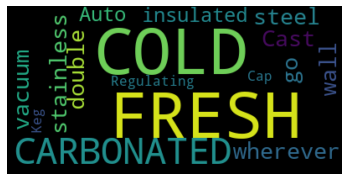

In [40]:
# Start with one review:
text = df['blurb'].iloc[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### mixed analysis

### projects per weekday

In [41]:
df.groupby(["target"])["funded_rate"].mean().sort_values(ascending=False)

target
True     10.350080
False     0.117567
Name: funded_rate, dtype: float64

In [42]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'currency', 'goal', 'location', 'name', 'spotlight', 'staff_pick',
       'state', 'state_changed_at', 'category_name', 'category_analytics_name',
       'category_slug', 'category_parent_name', 'created_at_date',
       'created_at_time', 'created_at_weekday', 'launched_at_date',
       'launched_at_time', 'launched_at_weekday', 'deadline_date',
       'deadline_time', 'deadline_weekday', 'project_duration', 'goal_reached',
       'funded_rate', 'target'],
      dtype='object')

### projects per category

category_parent_name

### Check for Correlation

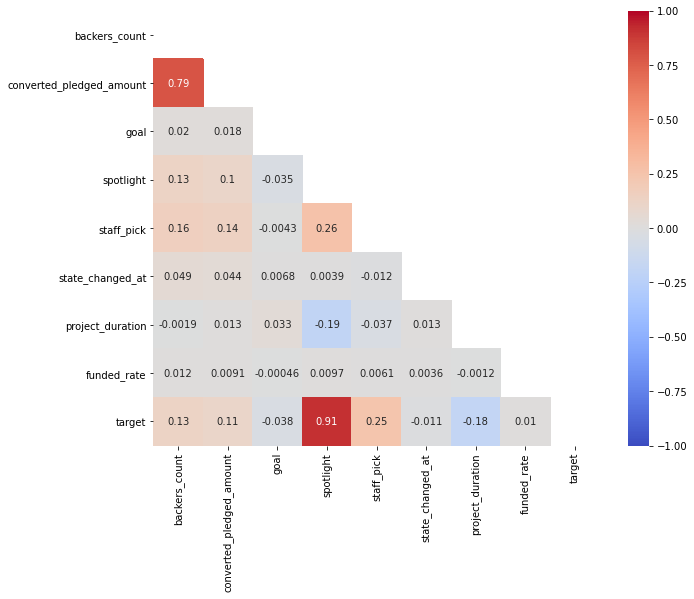

In [43]:
#round(df.corr()['death_event'].sort_values(ascending=False),2)

# create correlation heatmap 

mask = np.zeros_like(df.corr())

mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

plt.show()

## data imbalances

### check whether data is imbalanced

True     105233
False     97202
Name: target, dtype: int64

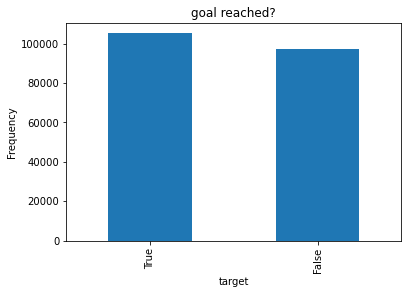

In [44]:
pd.value_counts(df['target']).plot.bar()
plt.title('goal reached?')
plt.xlabel('target')
plt.ylabel('Frequency')
df['target'].value_counts()

**NO** our data is balanced, as we have 104.174 True values and 95.965 False values

### deal with imbalances

## next steps

### to do's 